In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
from jax import grad, vmap, jit
from functools import partial
from jax.flatten_util import ravel_pytree
import jax.random as random
from jax.lax import cond, scan
import jax.example_libraries.optimizers as optimizers
key = random.PRNGKey(2022)

from utils_node import init_params_damage
from utils_node import RK_forward_pass_nobias as NODE_nobias, RK_forward_pass as NODE

import matplotlib.pyplot as plt
import pandas as pd
import pickle


from diffrax import diffeqsolve, ODETerm, SaveAt#, Heun as mysolver
from diffrax import Dopri5 as mysolver
from diffrax import Heun as mysolver

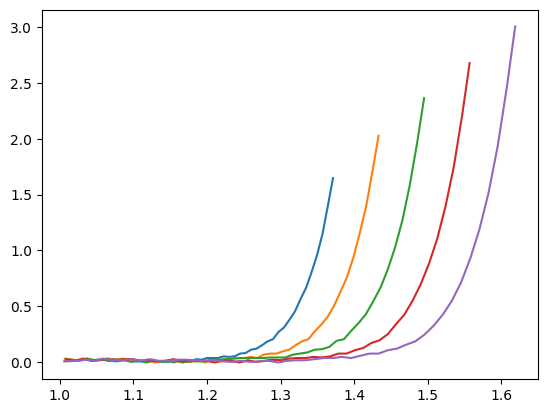

In [2]:
data = pd.read_csv('data/Dermis/DamageData/PA_Breast_Dermis1Data.csv')
def extract_numbers_and_cycle(value):
    parts = value.split('-')
    number = int(parts[0])
    cycle = parts[1] if len(parts) > 1 else None
    return pd.Series({'#': number, 'Cycle': cycle})

# Apply the custom function to the 'Cycle' column
data[['#', 'Cycle']] = data['Cycle'].apply(extract_numbers_and_cycle)
data = data[['SetName', '#', 'Cycle', 'Time_S', 'Size_mm', 'Displacement_mm', 'Force_N']]
data = data.rename(columns={'Cycle': 'Type', '#': 'Cycle'})
L0 = np.min(data['Size_mm'])

#Only keep the last cycle
data = data[data.Cycle==5]
data = data[data.Type == 'Recover']
setnames = np.unique(data['SetName'])
l = np.min([len(data[data['SetName']==setname]) for setname in setnames]) #get the minimum length of data so we have a common length

time_gt = []
disp_gt = []
sgmx_gt = []
for setname in setnames:
    time_gt.append(data[data['SetName']==setname]['Time_S'][:l])
    disp_gt.append(np.flip(data[data['SetName']==setname]['Displacement_mm'][:l]))
    sgmx_gt.append(np.flip(data[data['SetName']==setname]['Force_N'][:l]/20.0))
time_gt = np.array(time_gt); disp_gt = np.array(disp_gt); sgmx_gt = np.array(sgmx_gt)
lmbx_gt = 1.0+disp_gt/L0


# Get rid of the jumps in time
t0 = 0.0
for i in range(len(time_gt)):
    time_gt[i] = time_gt[i] - time_gt[i][0] + t0
    t0 = time_gt[i][-1]


n_curve = len(time_gt)
for i in range(n_curve):
    plt.plot(lmbx_gt[i], sgmx_gt[i])

In [3]:
#Psi functions
def Psi1_fn(params, I1):
    params, bias = params
    return NODE_nobias(I1-3, params) + jnp.exp(bias)
def Psi2_fn(params, I2):
    params, bias = params
    return NODE_nobias(I2-3, params) + jnp.exp(bias)
def Psiv_fn(params, Iv):
    params, theta = params
    Psiv = NODE_nobias(Iv-1, params)
    return jnp.maximum(Psiv, 0.0)
def Psiw_fn(params, Iw):
    params, theta = params
    Psiw = NODE_nobias(Iw-1, params)
    return jnp.maximum(Psiw, 0.0)
Psi_fns = (Psi1_fn, Psi2_fn, Psiv_fn, Psiw_fn)

def f(d, params):
    return 1.0-d
f_vmap = vmap(f, in_axes=(0, None))
def G(tau, params):
    return NODE(tau, params)
G_vmap = vmap(G, in_axes=(0, None))

In [4]:
def eval_Cauchy(lmbx, lmby, d, params):
    params_Psi_list, params_f_list, params_G_list, _ = params
    params_1, params_2, params_v, params_w = params_Psi_list

    lmbz = 1.0/(lmbx*lmby)
    F = jnp.array([[lmbx, 0, 0],
                   [0, lmby, 0],
                   [0, 0, lmbz]])
    C = F.T @ F
    C2 = C @ C
    Cinv = jnp.linalg.inv(C)
    theta_v = params_v[1]
    theta_w = params_w[1]
    v0 = jnp.array([jnp.sin(theta_v), jnp.cos(theta_v), 0])
    w0 = jnp.array([jnp.sin(theta_w), jnp.cos(theta_w), 0])
    V0 = jnp.outer(v0, v0)
    W0 = jnp.outer(w0, w0)

    I1 = C[0,0] + C[1,1] + C[2,2]
    trC2 = C2[0,0] + C2[1,1] + C2[2,2]
    I2 = 0.5*(I1**2 - trC2)
    Iv = jnp.einsum('ij,ij',C,V0)
    Iw = jnp.einsum('ij,ij',C,W0)

    f1 = f(d[0], params_f_list[0])
    f2 = f(d[1], params_f_list[1])
    f3 = f(d[2], params_f_list[2])
    f4 = f(d[3], params_f_list[3])
    Psi1 = jnp.maximum(f1,0.0)*Psi1_fn(params_1, I1)
    Psi2 = jnp.maximum(f2,0.0)*Psi2_fn(params_2, I2)
    Psiv = jnp.maximum(f3,0.0)*Psiv_fn(params_v, Iv)
    Psiw = jnp.maximum(f4,0.0)*Psiw_fn(params_w, Iw)

    p = -C[2,2]*(2*Psi1 + 2*Psi2*(I1 - C[2,2]) + 2*Psiv*V0[2,2] + 2*Psiw*W0[2,2])
    S = p*Cinv + 2*Psi1*jnp.eye(3) + 2*Psi2*(I1*jnp.eye(3)-C) + 2*Psiv*V0 + 2*Psiw*W0

    sgm = F @ (S @ F.T)
    return sgm
eval_Cauchy_vmap = vmap(eval_Cauchy, in_axes=(0,0,0,None), out_axes = 0)
eval_Cauchy_vmap2 = vmap(eval_Cauchy, in_axes=(0,0,None,None), out_axes = 0)

In [5]:
@jit
def ddot_fn(params, y, I, Idot):
    params_Psi_list, params_f_list, params_G_list, r_init = params
    ddot_list = []
    rdot_list = []
    for i in range(4):
        Ii          = I[i]
        Ii_dot      = Idot[i]
        di          = y[i]
        ri          = y[4+i]
        Psi_fn      = Psi_fns[i]
        params_Psi  = params_Psi_list[i]
        params_f    = params_f_list[i]
        params_G    = params_G_list[i]

        Psi0 = Psi_fn(params_Psi, Ii)
        dfdd = grad(f)(di, params_f)
        taui = -Psi0*dfdd

        #check if g<0
        g = G(taui, params_G) - G(ri, params_G)
        def true_fun(): #What to return for rdot & ddot if g<0
            return 0.0, 0.0
        def false_fun():
            Psi0dot = Psi0*Ii_dot
            dGdtau = grad(G)(taui, params_G)
            d2fdd2 = grad(grad(f))(di, params_f)
            ddot = -(Psi0dot*dfdd*dGdtau)/(1+Psi0*d2fdd2*dGdtau)
            rdot = -Psi0dot*dfdd - Psi0*dfdd*ddot
            return ddot, rdot
        ddot, rdot = cond(g<0, true_fun, false_fun)
        ddot_list.append(ddot)
        rdot_list.append(rdot)
    return jnp.array(ddot_list + rdot_list)

def I_Idot_uniaxial(lmb_dot, t, theta_v, theta_w):
    lmbx = 1.0 + lmb_dot*t
    lmby = lmbz = 1.0/jnp.sqrt(lmbx)
    I1 = lmbx**2 + 2.0/lmbx # = lmbx**2 + lmby**2 + lmbz**2
    I1dot = 2*lmbx*lmb_dot - 2*lmbx**(-2)*lmb_dot
    I2 = 2*lmbx + 1.0/lmbx**2 # = lmbx**2*lmby**2 + lmbx**2*lmbz**2 + lmby**2*lmbz**2
    I2dot = 2*lmb_dot - 2*lmbx**(-3)*lmb_dot
    Iv = lmbx**2*jnp.sin(theta_v)**2 + 1.0/lmbx*jnp.cos(theta_v)**2 # = lmbx**2*jnp.sin(theta_v)**2 + lmby**2*jnp.cos(theta_v)**2
    Ivdot = 2*lmbx*jnp.sin(theta_v)**2*lmb_dot - lmbx**(-2)*jnp.cos(theta_v)**2*lmb_dot
    Iw = lmbx**2*jnp.sin(theta_w)**2 + 1.0/lmbx*jnp.cos(theta_w)**2 # = lmbx**2*jnp.sin(theta_w)**2 + lmby**2*jnp.cos(theta_w)**2
    Iwdot = 2*lmbx*jnp.sin(theta_w)**2*lmb_dot - lmbx**(-2)*jnp.cos(theta_w)**2*lmb_dot
    I = [I1, I2, Iv, Iw]
    Idot = [I1dot, I2dot, Ivdot, Iwdot]
    return I, Idot

@jit
def integrate_d_uniax(params, lmb_max, y0):
    theta_v = params[0][2][1]
    theta_w = params[0][3][1]
    
    t_peak = 1.0
    lmb_dot = (lmb_max-1.0)/t_peak
    def yprime(t, y, args=None):
        I, Idot = I_Idot_uniaxial(lmb_dot, t, theta_v, theta_w)
        return ddot_fn(params, y, I, Idot)
    # y = odeint(yprime, y0, t=jnp.linspace(0.0,1.0))
    term = ODETerm(yprime)
    solver = mysolver()
    saveat = SaveAt(ts=jnp.linspace(0.0,1.0))
    solution = diffeqsolve(term, solver, t0=0.0, t1=1.0, dt0=0.1, y0=y0, saveat=saveat)
    return solution.ys


In [6]:
@jit
def repeat_uniax(params, lmbx):
    # r0 = params[-1]
    # y0 = jnp.array([0.0,0.0,0.0,0.0] + r0) #take exp to make sure it is positive
    y0 = jnp.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
    d = []
    for i in range(n_curve):
        lmb_max = jnp.max(lmbx[i])
        y = integrate_d_uniax(params, lmb_max, y0)
        d.append(y)
        y0 = y[-1]
    return d

[Text(0.5, 0, 'time [s]'), Text(0, 0.5, '$f(d)$')]

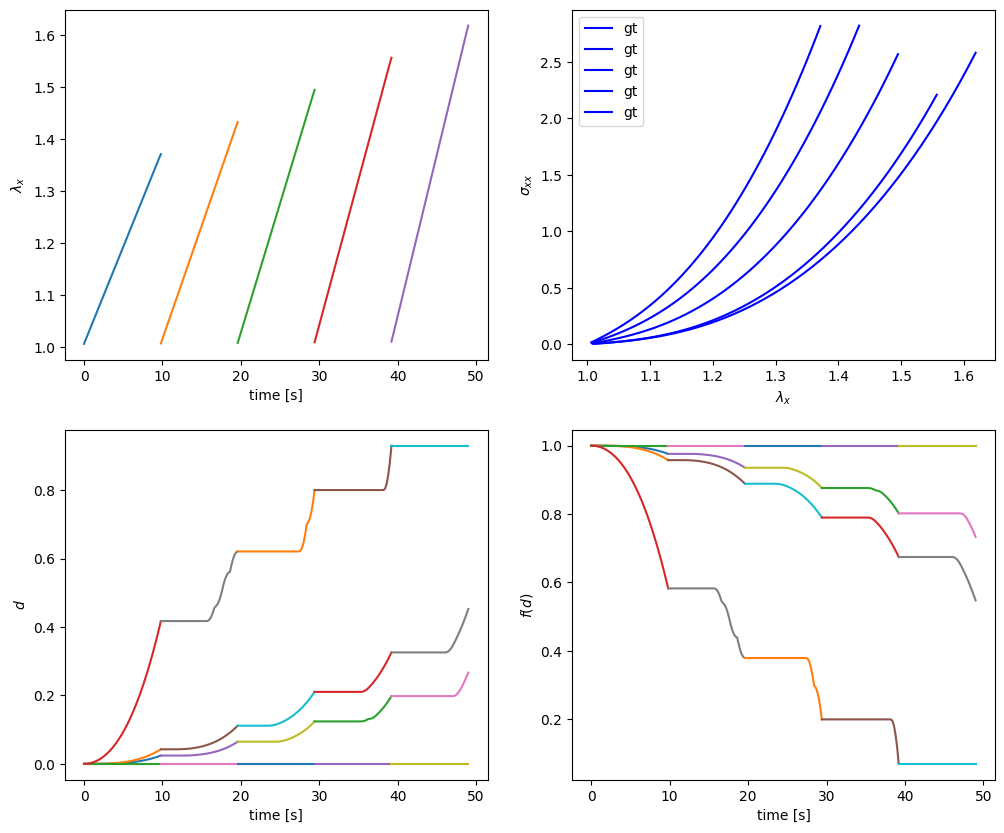

In [7]:
params = init_params_damage(key)
f_params = params[1]
d = repeat_uniax(params, lmbx_gt)
fig, ax = plt.subplots(2,2,figsize=(12,10))

for i in range(5):
    time = time_gt[i]
    di = d[i]
    lmbx = lmbx_gt[i]
    lmby = 1.0/np.sqrt(lmbx)
    sgmx_pr = eval_Cauchy_vmap2(lmbx, lmby, di[-1], params)

    for j in range(4):
        ax[1,0].plot(time, di[:,j])
        ax[1,1].plot(time, f_vmap(di[:,j], f_params[j]))

    ax[0,0].plot(time, lmbx)
    ax[0,1].plot(lmbx, sgmx_pr[:,0,0], 'b-', label='gt')
ax[0,0].set(xlabel='time [s]', ylabel = '$\lambda_x$')
ax[0,1].legend()
ax[0,1].set(xlabel='$\lambda_x$', ylabel='$\sigma_{xx}$')

ax[1,0].set(xlabel='time [s]', ylabel='$d$')
ax[1,1].set(xlabel='time [s]', ylabel='$f(d)$')

# Set up training

In [8]:
def loss(params, lmbx_gt, sgmx_gt):
    d = repeat_uniax(params, lmbx_gt)
    loss = []
    for i in range(5):
        di = d[i]
        lmbx = lmbx_gt[i]
        lmby = 1.0/jnp.sqrt(lmbx)
        sgmx_pr = eval_Cauchy_vmap2(lmbx, lmby, di[-1], params)[:,0,0]
        loss.append((sgmx_gt-sgmx_pr)**2)
    return jnp.mean(jnp.array(loss))

@partial(jit, static_argnums=(0,2,3,))
def step(loss, i, get_params, opt_update, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, Y_batch)
    return opt_update(i, g, opt_state)

def train(loss, X, Y, get_params, opt_update, opt_state, key, nIter = 10000, print_freq=1000, metric_fns=None, batch_size=None):
    train_loss = []
    metrics = []
    for it in range(nIter):
        key, subkey = random.split(key)
        if batch_size is None:
            X_batch = X
            Y_batch = Y
        else:
            idx = random.choice(key=key, a=jnp.arange(len(X)), shape=(batch_size,), replace=False)
            X_batch = X[idx]
            Y_batch = Y[idx]
        opt_state = step(loss, it, get_params, opt_update, opt_state, X_batch, Y_batch)         
        if (it+1)% print_freq == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            if metric_fns is not None:
                m = []
                for metric_fn in metric_fns:
                    m.append(metric_fn(params, X, Y))
                metrics.append(m)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, metrics

In [9]:
params = init_params_damage(key)
opt_init, opt_update, get_params = optimizers.adam(1.e-4) #Original: 1.e-4
opt_state = opt_init(params)

# Train
inp = lmbx_gt
out = sgmx_gt
params, train_loss, _ = train(loss, inp, sgmx_gt, get_params, opt_update, opt_state, key, nIter = 400000, print_freq=100)

it 100, train loss = 5.220454e-01
it 200, train loss = 5.589617e-01
it 300, train loss = 4.420136e-01
it 400, train loss = 3.678613e-01
it 500, train loss = 3.393231e-01
it 600, train loss = 4.175574e-01
it 700, train loss = 3.166573e-01
it 800, train loss = 3.302020e-01
it 900, train loss = 2.679193e-01
it 1000, train loss = 2.296011e-01
it 1100, train loss = 2.688340e-01
it 1200, train loss = 2.270425e-01
it 1300, train loss = 1.928025e-01
it 1400, train loss = 1.815065e-01
it 1500, train loss = 1.887836e-01
it 1600, train loss = 1.894227e-01
it 1700, train loss = 1.664825e-01
it 1800, train loss = 1.883575e-01
it 1900, train loss = 1.730429e-01
it 2000, train loss = 1.640432e-01
it 2100, train loss = 1.571790e-01
it 2200, train loss = 1.547798e-01
it 2300, train loss = 1.539979e-01
it 2400, train loss = 1.473892e-01
it 2500, train loss = 1.348696e-01
it 2600, train loss = 1.285461e-01
it 2700, train loss = 1.247229e-01
it 2800, train loss = 1.244005e-01
it 2900, train loss = 1.24110

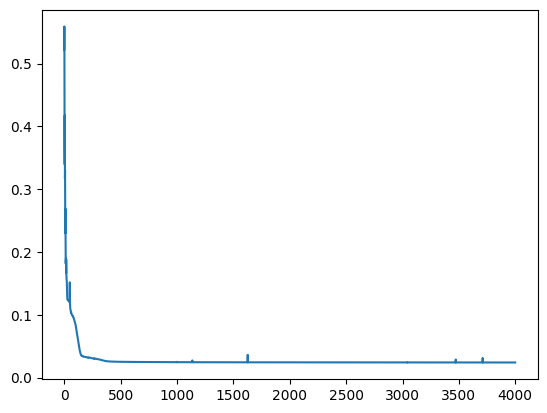

In [10]:
plt.plot(train_loss)

[Text(0.5, 0, 'time [s]'), Text(0, 0.5, '$f(d)$')]

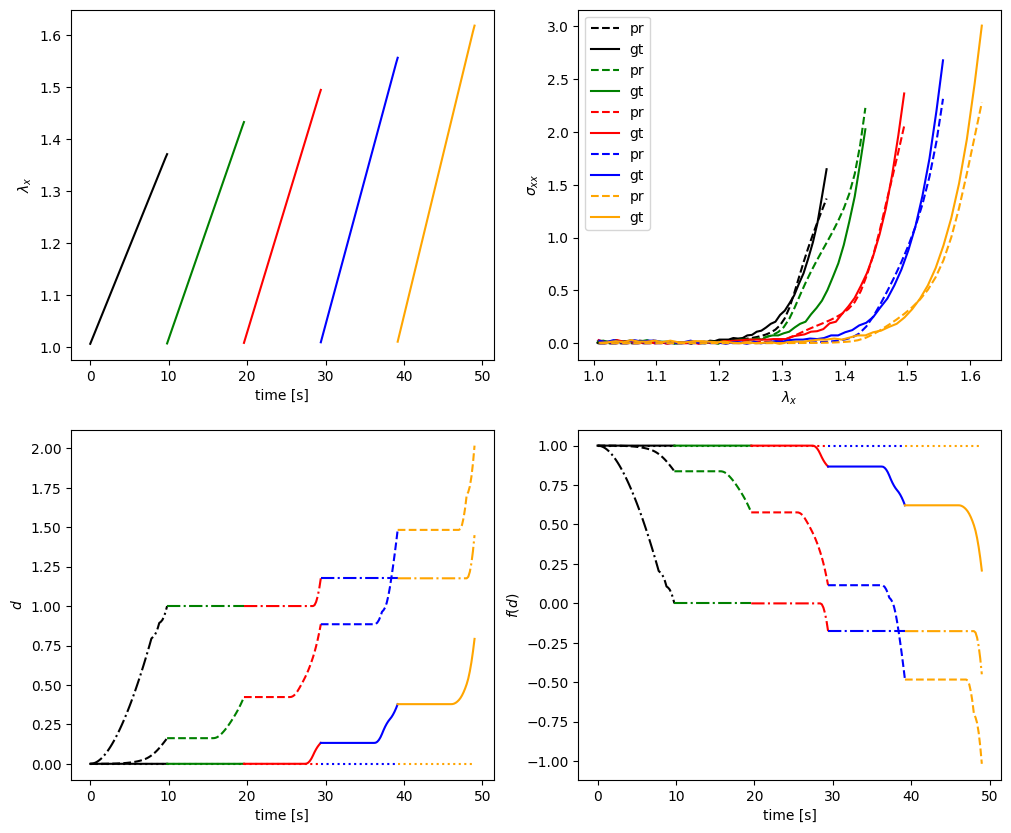

In [11]:
f_params = params[1]
d = repeat_uniax(params, lmbx_gt)
fig, ax = plt.subplots(2,2,figsize=(12,10))

cols = ['black', 'green', 'red', 'blue', 'orange']
lnstyles = ['solid', 'dashed', 'dotted', 'dashdot']
for i in range(5):
    col = cols[i]
    time = time_gt[i]
    di = d[i]
    lmbx = lmbx_gt[i]
    lmby = 1.0/np.sqrt(lmbx)
    sgmx = sgmx_gt[i]
    sgmx_pr = eval_Cauchy_vmap2(lmbx, lmby, di[-1], params)

    for j in range(4):
        lns = lnstyles[j]
        ax[1,0].plot(time, di[:,j], col, linestyle=lns)
        ax[1,1].plot(time, f_vmap(di[:,j], f_params[j]), col, linestyle=lns)

    ax[0,0].plot(time, lmbx, col)
    ax[0,1].plot(lmbx, sgmx_pr[:,0,0], col, linestyle='dashed', label='pr')
    ax[0,1].plot(lmbx, sgmx, col, linestyle='solid', label='gt')
ax[0,0].set(xlabel='time [s]', ylabel = '$\lambda_x$')
ax[0,1].legend()
ax[0,1].set(xlabel='$\lambda_x$', ylabel='$\sigma_{xx}$')

ax[1,0].set(xlabel='time [s]', ylabel='$d$')
ax[1,1].set(xlabel='time [s]', ylabel='$f(d)$')

[Text(0.5, 0, 'time [s]'), Text(0, 0.5, '$f(d)$')]

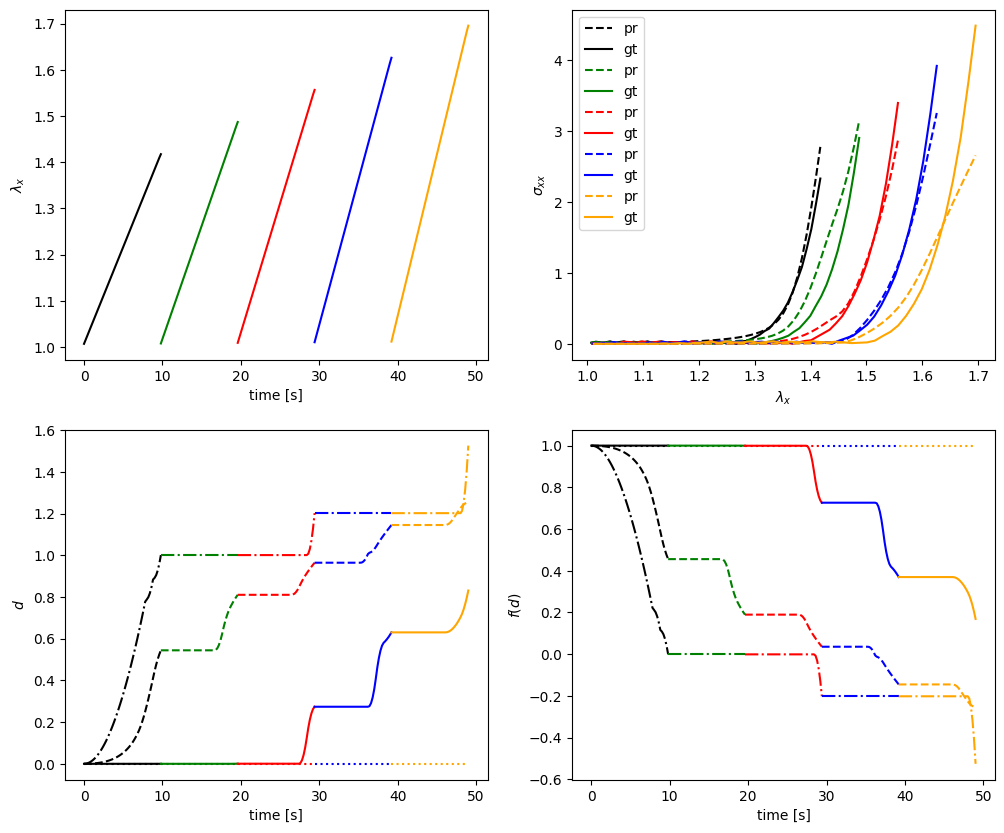

In [11]:
f_params = params[1]
d = repeat_uniax(params, lmbx_gt)
fig, ax = plt.subplots(2,2,figsize=(12,10))

cols = ['black', 'green', 'red', 'blue', 'orange']
lnstyles = ['solid', 'dashed', 'dotted', 'dashdot']
for i in range(5):
    col = cols[i]
    time = time_gt[i]
    di = d[i]
    lmbx = lmbx_gt[i]
    lmby = 1.0/np.sqrt(lmbx)
    sgmx = sgmx_gt[i]
    sgmx_pr = eval_Cauchy_vmap2(lmbx, lmby, di[-1], params)

    for j in range(4):
        lns = lnstyles[j]
        ax[1,0].plot(time, di[:,j], col, linestyle=lns)
        ax[1,1].plot(time, f_vmap(di[:,j], f_params[j]), col, linestyle=lns)

    ax[0,0].plot(time, lmbx, col)
    ax[0,1].plot(lmbx, sgmx_pr[:,0,0], col, linestyle='dashed', label='pr')
    ax[0,1].plot(lmbx, sgmx, col, linestyle='solid', label='gt')
ax[0,0].set(xlabel='time [s]', ylabel = '$\lambda_x$')
ax[0,1].legend()
ax[0,1].set(xlabel='$\lambda_x$', ylabel='$\sigma_{xx}$')

ax[1,0].set(xlabel='time [s]', ylabel='$d$')
ax[1,1].set(xlabel='time [s]', ylabel='$f(d)$')

In [14]:
@jit
def ddot_fn2(params, y, I, Idot):
    params_Psi_list, params_f_list, params_G_list, r_init = params
    ddot_list = []
    rdot_list = []
    Psi0dot_list = []
    dGdtau_list = []
    dfdd_list = []
    Psi0_list = []
    for i in range(4):
        Ii          = I[i]
        Ii_dot      = Idot[i]
        di          = y[i]
        ri          = y[4+i]
        Psi_fn      = Psi_fns[i]
        params_Psi  = params_Psi_list[i]
        params_f    = params_f_list[i]
        params_G    = params_G_list[i]

        Psi0 = Psi_fn(params_Psi, Ii)
        dfdd = grad(f)(di, params_f)
        taui = -Psi0*dfdd

        #check if g<0
        g = G(taui, params_G) - G(ri, params_G)
        Psi0dot = Psi0*Ii_dot
        dGdtau = grad(G)(taui, params_G)
        def true_fun(): #What to return for rdot & ddot if g<0
            return 0.0, 0.0
        def false_fun():
            ddot = -(Psi0dot*dfdd*dGdtau)/(1+Psi0*dfdd*dGdtau)
            rdot = -Psi0dot*dfdd - Psi0*dfdd*ddot
            return ddot, rdot
        ddot, rdot = cond(g<0, true_fun, false_fun)
        ddot_list.append(ddot)
        rdot_list.append(rdot)
        Psi0dot_list.append(Psi0dot)
        dGdtau_list.append(dGdtau)
        dfdd_list.append(dfdd)
        Psi0_list.append(Psi0)
    return jnp.array(ddot_list + rdot_list), Psi0dot_list, dGdtau_list, dfdd_list, Psi0_list

def integrate_d_uniax2(params, lmb_max, y0):
    theta_v = params[0][2][1]
    theta_w = params[0][3][1]
    
    t_peak = 1.0
    lmb_dot = (lmb_max-1.0)/t_peak
    def yprime(t, y, args=None):
        I, Idot = I_Idot_uniaxial(lmb_dot, t, theta_v, theta_w)
        return ddot_fn2(params, y, I, Idot)[0]
    # y = odeint(yprime, y0, t=jnp.linspace(0.0,1.0))
    term = ODETerm(yprime)
    solver = mysolver()
    saveat = SaveAt(ts=jnp.linspace(0.0,1.0))
    solution = diffeqsolve(term, solver, t0=0.0, t1=1.0, dt0=0.1, y0=y0, saveat=saveat)


    # return Idot, rdot etc as well
    ts=jnp.linspace(0.0,1.0)
    Is = []
    Idots = []
    ydots = []
    Psi0dots = []
    dGdtaus = []
    dfdds = []
    Psi0s = []
    for t, y in zip(ts, solution.ys):
        I, Idot = I_Idot_uniaxial(lmb_dot, t, theta_v, theta_w)
        ydot, Psi0dot, dGdtau, dfdd, Psi0 = ddot_fn2(params, y, I, Idot)
        Is.append(I)
        Idots.append(Idot)
        ydots.append(ydot)
        Psi0dots.append(Psi0dot)
        dGdtaus.append(dGdtau)
        dfdds.append(dfdd)
        Psi0s.append(Psi0)

    return solution.ys, Is, Idots, ydots, Psi0dots, dGdtaus, dfdds, Psi0s

def repeat_uniax2(params, lmbx):
    r0 = params[-1]
    y0 = jnp.array([0.0,0.0,0.0,0.0] + r0)
    d = []
    Is = []
    Idots = []
    ydots = []
    Psi0dots = []
    dGdtaus = []
    dfdds = []
    Psi0s = []
    for i in range(n_curve):
        lmb_max = jnp.max(lmbx[i])
        y, I, Idot, ydot, Psi0dot, dGdtau, dfdd, Psi0 = integrate_d_uniax2(params, lmb_max, y0)
        Is.append(I)
        Idots.append(Idot)
        ydots.append(ydot)
        Psi0dots.append(Psi0dot)
        dGdtaus.append(dGdtau)
        dfdds.append(dfdd)
        Psi0s.append(Psi0)
        d.append(y)
        y0 = y[-1]
    return d, Is, Idots, ydots, Psi0dots, dGdtaus, dfdds, Psi0s

[(-10.0, 10.0)]

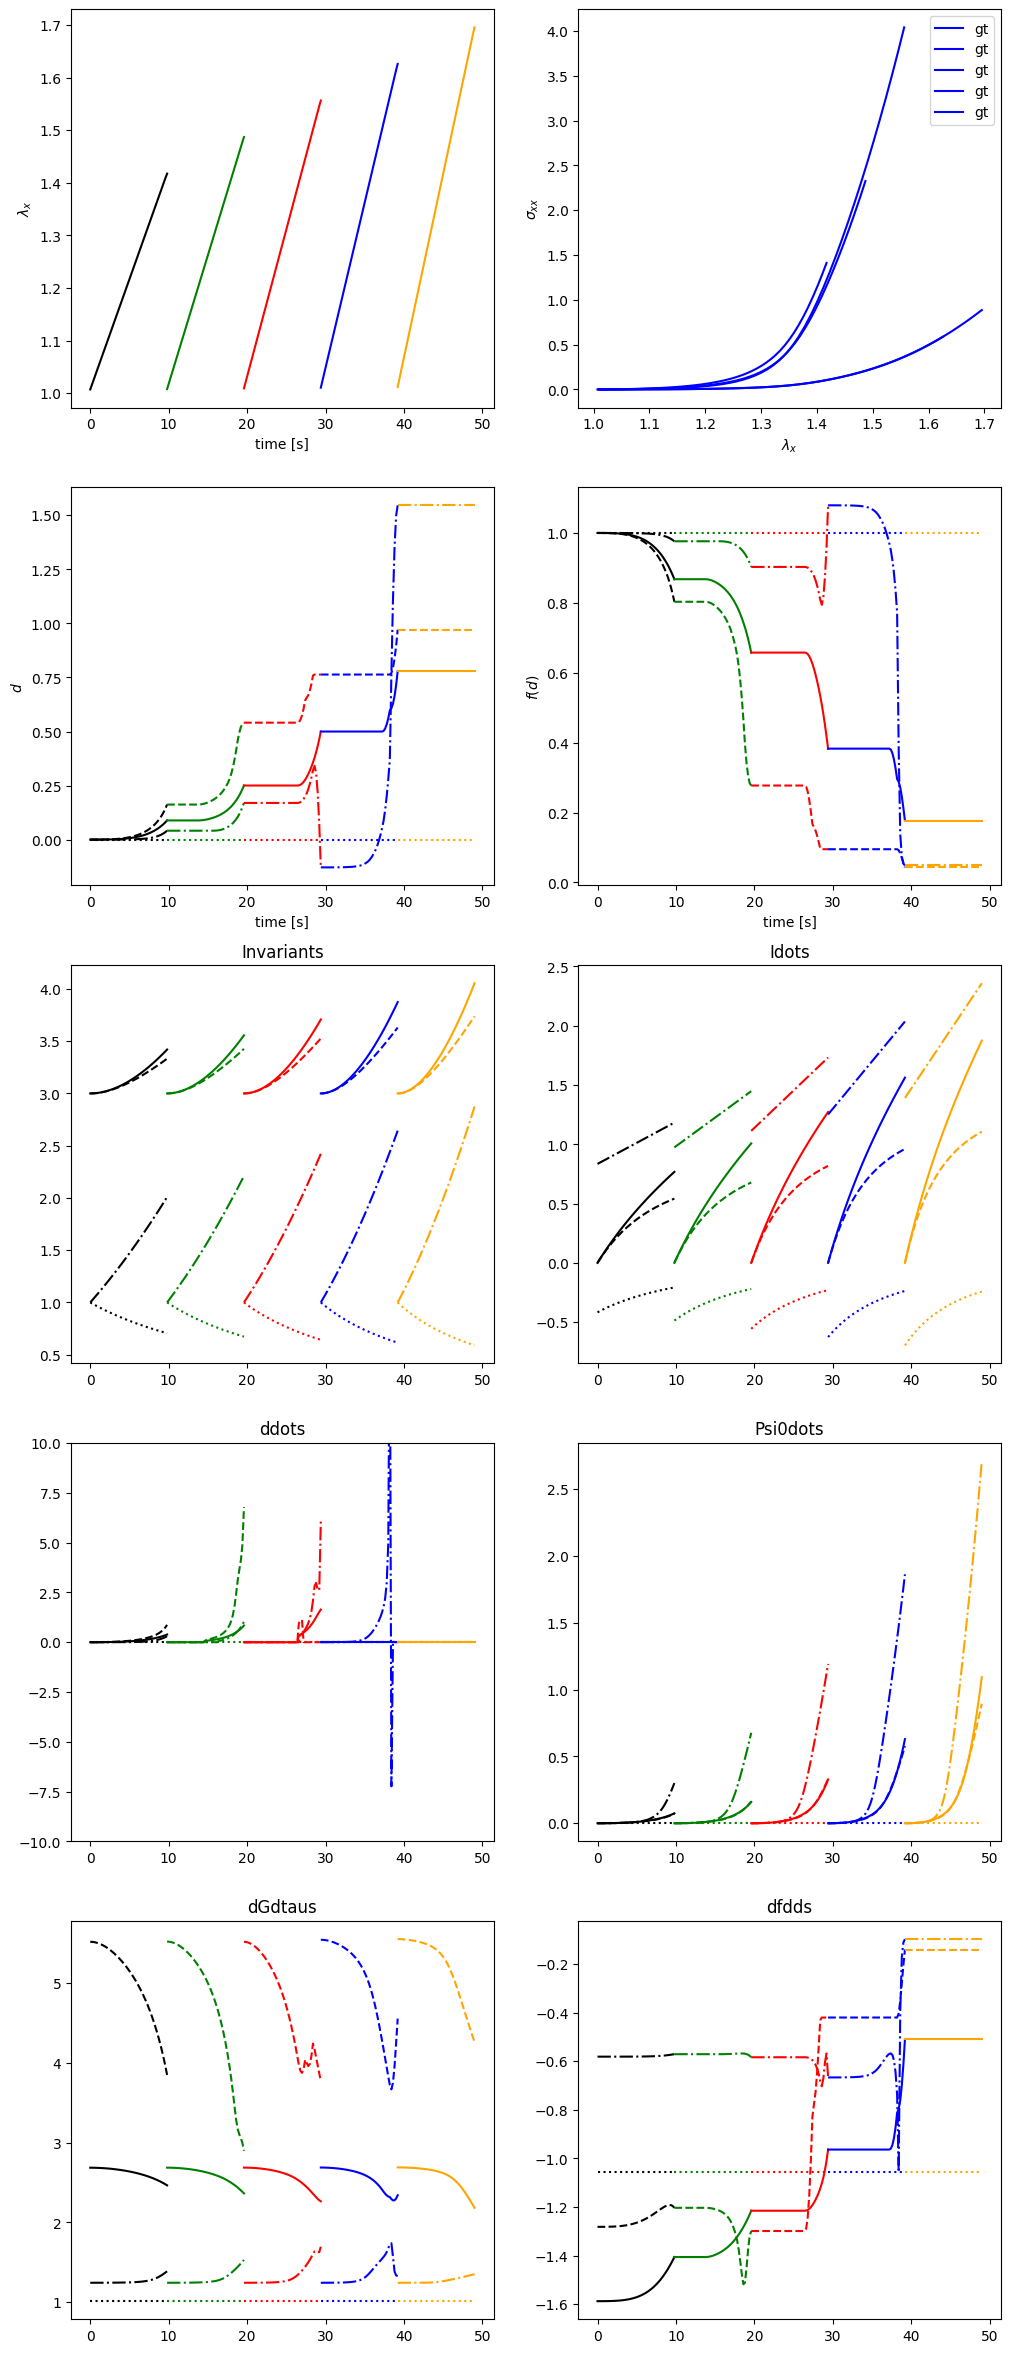

In [15]:
f_params = params[1]
d, Is, Idots, ydots, Psi0dots, dGdtaus, dfdds, Psi0s = repeat_uniax2(params, lmbx_gt)
Is = np.array(Is)
Idots = np.array(Idots)
ydots = np.array(ydots)
Psi0dots = np.array(Psi0dots)
dGdtaus = np.array(dGdtaus)
dfdds = np.array(dfdds)
Psi0s = np.array(Psi0s)
fig, ax = plt.subplots(5,2,figsize=(12,30))

cols = ['black', 'green', 'red', 'blue', 'orange']
lnstyles = ['solid', 'dashed', 'dotted', 'dashdot']
for i in range(5):
    col = cols[i]
    time = time_gt[i]
    di = d[i]
    lmbx = lmbx_gt[i]
    Ii = Is[i]
    Idoti = Idots[i]
    ddoti = ydots[i]
    Psi0doti = Psi0dots[i]
    dGdtaui = dGdtaus[i]
    dfddi = dfdds[i]
    Psi0i = Psi0s[i]

    
    lmby = 1.0/np.sqrt(lmbx)
    sgmx_pr = eval_Cauchy_vmap2(lmbx, lmby, di[-1], params)

    for j in range(4):
        lns = lnstyles[j]
        ax[1,0].plot(time, di[:,j], col, linestyle=lns)
        ax[1,1].plot(time, f_vmap(di[:,j], f_params[j]), col, linestyle=lns)

        ax[2,0].plot(time, Ii[:,j], col, linestyle=lns)
        ax[2,1].plot(time, Idoti[:,j], col, linestyle=lns)
        ax[3,0].plot(time, ddoti[:,j], col, linestyle=lns)
        ax[3,1].plot(time, Psi0doti[:,j], col, linestyle=lns)
        ax[4,0].plot(time, dGdtaui[:,j], col, linestyle=lns)
        ax[4,1].plot(time, dfddi[:,j], col, linestyle=lns)

    ax[0,0].plot(time, lmbx, col)
    ax[0,1].plot(lmbx, sgmx_pr[:,0,0], 'b-', label='gt')


ax[0,0].set(xlabel='time [s]', ylabel = '$\lambda_x$')
ax[0,1].legend()
ax[0,1].set(xlabel='$\lambda_x$', ylabel='$\sigma_{xx}$')

ax[1,0].set(xlabel='time [s]', ylabel='$d$')
ax[1,1].set(xlabel='time [s]', ylabel='$f(d)$')

ax[2,0].set(title='Invariants')
ax[2,1].set(title='Idots')
ax[3,0].set(title='ddots')
ax[3,1].set(title='Psi0dots')
ax[4,0].set(title='dGdtaus')
ax[4,1].set(title='dfdds')

ax[3,0].set(ylim=[-10,10])

In [26]:
testdG = dGdtaus.reshape([-1,4])
testdf = dfdds.reshape([-1,4])
testPsi0 = Psi0s.reshape([-1,4])

test = testdG*testdf*testPsi0
print(np.min(test))

-1.3742720032952787


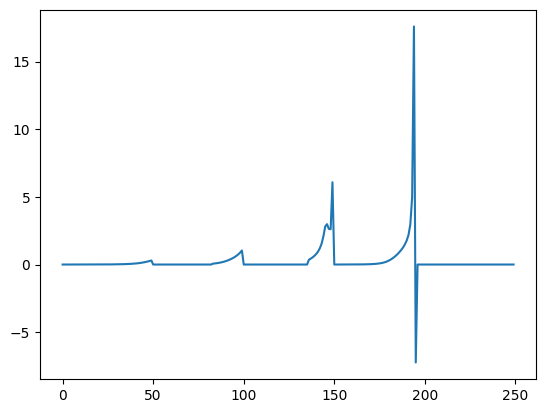

In [24]:
test = ydots.reshape([-1,8])[:,3]
plt.plot(test)

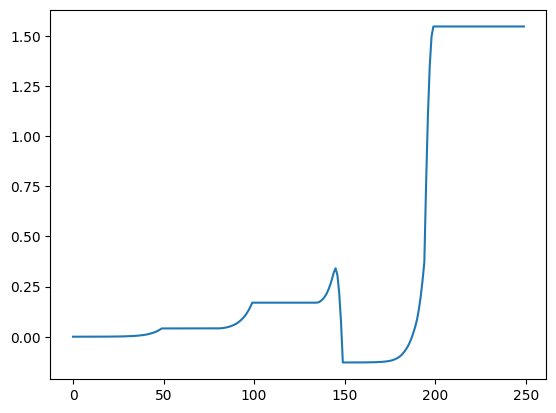

In [21]:
test = np.array(d)
test.shape
test = test.reshape([-1,8])[:,3]
plt.plot(test)